In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier

# Get Data

In [2]:
train = pd.read_csv('train.csv')
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


# Clean, Prepare & Manipulate Data

## 결측값 처리

In [3]:
## 결측값 확인
train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

### Age 결측값 처리

In [4]:
# Initial column을 생성해 Name column에서 이니셜을 추출해 넣는다.
train['Initial'] = 0
for i in train:
    train['Initial'] = train.Name.str.extract('([A-Za-z]+)\.')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


In [5]:
train['Initial'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess',
       'Jonkheer'], dtype=object)

In [6]:
train['Initial'].replace(['Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess',
       'Jonkheer'],['Others','Others','Others','Others','Others','Others','Others','Others','Others','Others','Others','Others','Others','Others'],inplace=True)

In [7]:
train['Initial'].unique()

array(['Mr', 'Mrs', 'Miss', 'Others'], dtype=object)

In [8]:
train.groupby('Initial')['Age'].mean()

Initial
Miss      21.773973
Mr        32.368090
Mrs       35.898148
Others    20.430161
Name: Age, dtype: float64

In [9]:
train.loc[(train.Age.isnull())&(train.Initial=='Miss'),'Age']=21
train.loc[(train.Age.isnull())&(train.Initial=='Mr'),'Age']=32
train.loc[(train.Age.isnull())&(train.Initial=='Mrs'),'Age']=35
train.loc[(train.Age.isnull())&(train.Initial=='Others'),'Age']=20

### Embarked 결측값 처리

In [10]:
train.groupby('Embarked')['PassengerId'].count()

Embarked
C    168
Q     77
S    644
Name: PassengerId, dtype: int64

In [11]:
train['Embarked'].fillna('S',inplace=True)

## 연속형 변수를 범주형 변수로 변환

### Age 변환

In [12]:
train['age_bin']=0
train.loc[train['Age']<=15, 'age_bin']=0
train.loc[(train['Age']>15) & (train['Age']<=30), 'age_bin']=1
train.loc[(train['Age']>30) & (train['Age']<=50), 'age_bin']=2
train.loc[(train['Age']>50) & (train['Age']<=65), 'age_bin']=3
train.loc[train['Age']>65, 'age_bin']=4

### Fare 변환

In [13]:
train['fare_range'] = pd.qcut(train['Fare'],4)
train.groupby(['fare_range'])['Survived'].mean().to_frame()

,Survived
fare_range,
"(-0.001, 7.91]",0.197309
"(7.91, 14.454]",0.303571
"(14.454, 31.0]",0.454955
"(31.0, 512.329]",0.581081


In [14]:
train['fare_bin']=0
train.loc[train['Fare']<=7.91, 'fare_bin']=0
train.loc[(train['Fare']>7.91) & (train['Fare']<=14.454), 'fare_bin']=1
train.loc[(train['Fare']>14.454) & (train['Fare']<=31.0), 'fare_bin']=2
train.loc[train['Fare']>31.0, 'fare_bin']=3

## 동승객 column 추가
Parch와 Sibsp를 더한 값으로 같이 탑승한 전체 가족 수에 대한 column을 생성한다. 혼자 탑승한 승객은 Alone으로 표시한다.

In [15]:
train['family']=0
train['family']=train['Parch']+train['SibSp']
train['Alone']=0
train.loc[train.family==0,'Alone']=1

## 성별, 탑승 위치, 이니셜을 mapping

In [16]:
train['Sex'].replace(['male','female'],[0,1],inplace=True)
train['Embarked'].replace(['S','C','Q'],[0,1,2],inplace=True)
train['Initial'].replace(['Miss','Mr','Mrs','Others'],[0,1,2,3],inplace=True)

## 사용하지 않는 column 삭제

In [17]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial,age_bin,fare_range,fare_bin,family,Alone
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,0,1,1,"(-0.001, 7.91]",0,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,1,2,2,"(31.0, 512.329]",3,1,0
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,0,1,"(7.91, 14.454]",1,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,0,2,2,"(31.0, 512.329]",3,1,0
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,0,1,2,"(7.91, 14.454]",1,0,1


In [18]:
train1 = train.drop(columns=['PassengerId','Name','Age','SibSp','Parch','Ticket','Fare','Cabin','fare_range'],axis=1)
train1.head()

,Survived,Pclass,Sex,Embarked,Initial,age_bin,fare_bin,family,Alone
0,0,3,0,0,1,1,0,1,0
1,1,1,1,1,2,2,3,1,0
2,1,3,1,0,0,1,1,0,1
3,1,1,1,0,2,2,3,1,0
4,0,3,0,0,1,2,1,0,1


# Train Model

In [19]:
target = train1['Survived']
data = train1[['Pclass', 'Sex', 'Embarked', 'Initial', 'age_bin', 'fare_bin', 'family', 'Alone']]

In [20]:
train_input, test_input, train_target, test_target = train_test_split(data, target, random_state=42)

In [21]:
#로지스틱 회귀 인스턴스 생성
lr = LogisticRegression()
#훈련 데이터로 모델 훈련
lr.fit(train_input, train_target)

LogisticRegression()

# Test Data

In [22]:
lr.score(test_input, test_target)

0.7982062780269058

# Improve

In [23]:
target2 = train1['Survived']
data2 = train1[['Pclass', 'Sex', 'age_bin', 'fare_bin', 'family', 'Alone']]
train_input2, test_input2, train_target2, test_target2 = train_test_split(data2, target2, random_state=42)
lr.fit(train_input2, train_target2)

LogisticRegression()

In [25]:
lr.score(test_input2, test_target2)

0.8161434977578476

## RandomForest

In [26]:
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(train_input2, train_target2)
clf.score(test_input2, test_target2)

0.8071748878923767

(-1.0, 6.0)

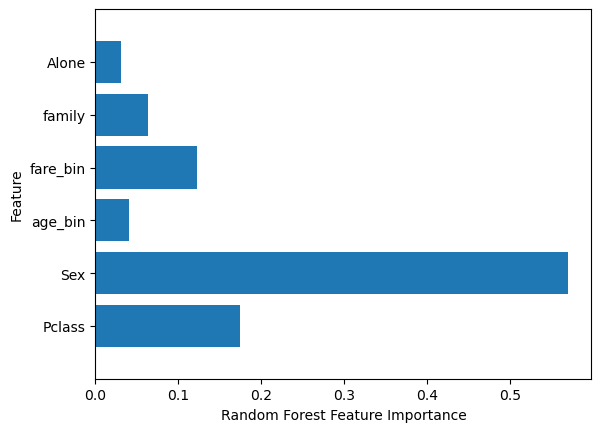

In [27]:
n_features = train_input2.shape[1]
plt.barh(np.arange(n_features), clf.feature_importances_, align="center")
plt.yticks(np.arange(n_features), test_input2.columns)
plt.xlabel("Random Forest Feature Importance")
plt.ylabel("Feature")
plt.ylim(-1, n_features)